In [1]:
import pandas as pd
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
num_samples = 1000

In [4]:
payload = np.random.normal(loc=145.205, scale=17.082, size=num_samples)

round_trip_distance = np.random.normal(loc=5, scale=1, size=num_samples)  

cycles_per_shift = np.random.normal(loc=1, scale=1, size=num_samples)  

total_hours_operation = np.random.normal(loc=8, scale=1, size=num_samples) 

awss = (round_trip_distance * cycles_per_shift) / total_hours_operation

temperature = np.random.normal(loc=30, scale=5, size=num_samples)  

tire_pressure = np.random.normal(loc=100, scale=10, size=num_samples)

The ideal air pressure for a dumper truck tire depends on the truck's weight and other factors, but generally ranges from 8 to 9 bar (116–131 PSI). However, most truckers tend to inflate their tires to between 85 and 105 PSI, with 95 PSI being the most common

In [5]:
anomalies = np.random.choice([0, 1], size=num_samples, p=[0.90, 0.10])  
tire_pressure = np.where(anomalies == 1, np.random.choice([np.random.uniform(60, 85), np.random.uniform(110, 140)], size=num_samples), tire_pressure)

tire_pressure = np.clip(tire_pressure, 60, 140)

anomaly = np.where((tire_pressure < 85) | (tire_pressure > 110), 1, 0)

In [6]:
df = pd.DataFrame({
    'Payload (Ton)': payload,
    'Round-trip Distance (km)': round_trip_distance,
    'Cycles/Shift': cycles_per_shift,
    'Total Hours Operation/Shift': total_hours_operation,
    'AWSS': awss,
    'Tire Pressure (psi)': tire_pressure,
    'Temperature (°C)': temperature,
    'Anomaly': anomaly
})


In [7]:
df.head()

,Payload (Ton),Round-trip Distance (km),Cycles/Shift,Total Hours Operation/Shift,AWSS,Tire Pressure (psi),Temperature (°C),Anomaly
0,153.689871,6.399355,0.324822,6.092192,0.341199,95.762403,25.682532,0
1,142.843169,5.924634,0.855481,7.139615,0.709900,95.465859,29.843983,0
2,156.268816,5.059630,0.207580,7.586394,0.138442,82.043568,30.090084,1
3,171.221396,4.353063,0.692038,9.887688,0.304671,96.699098,32.363152,0
4,141.205192,5.698223,-0.893615,8.556553,-0.595101,76.006273,23.165708,1


In [8]:
df.to_csv('anomaly_detection.csv', index=False)

In [9]:
X = df[['Payload (Ton)', 'AWSS', 'Tire Pressure (psi)', 'Temperature (°C)']]
y = df['Anomaly']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [12]:
lr_pred = lr.predict(X_test)

In [13]:
print("Accuracy:", accuracy_score(y_test, lr_pred))

Accuracy: 0.73


In [14]:
print("Classification Report:", classification_report(y_test, lr_pred))

Classification Report:               precision    recall  f1-score   support

           0       0.72      1.00      0.83       136
           1       1.00      0.16      0.27        64

    accuracy                           0.73       200
   macro avg       0.86      0.58      0.55       200
weighted avg       0.81      0.73      0.65       200



In [15]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train.values, y_train.values)

DecisionTreeClassifier()

In [16]:
dt_pred = dt.predict(X_test.values)

In [17]:
print("Accuracy:", accuracy_score(y_test, dt_pred))

Accuracy: 0.995


In [18]:
print("Classification Report:", classification_report(y_test, dt_pred))

Classification Report:               precision    recall  f1-score   support

           0       0.99      1.00      1.00       136
           1       1.00      0.98      0.99        64

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [19]:
def predict(payload, awss, tire_pressure, temperature, model):
    new_data = np.array([[payload, awss, tire_pressure, temperature]])
    anomaly_pred = model.predict(new_data)
    return anomaly_pred[0]

In [20]:
pred = predict(153.68, 0.34, 95.76, 25.68, dt)
print(f"Predicted Anomaly: {pred}")

Predicted Anomaly: 0


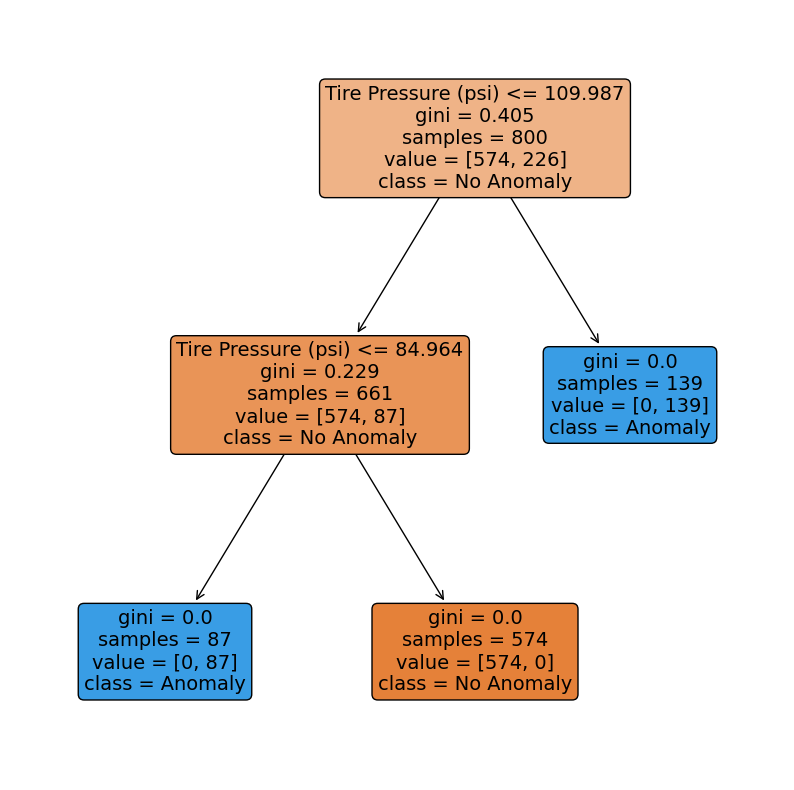

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=['No Anomaly', 'Anomaly'], rounded=True)
plt.show()

In [22]:
import joblib

joblib.dump(dt, "anomaly.pkl")

['anomaly.pkl']

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Create a simple neural network that approximates the decision tree
model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(set(y_train)), activation='softmax')  # Assuming a classification task
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Save the TensorFlow model
model.save('tf_model.h5')

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5681 - loss: 1.6630 - val_accuracy: 0.7500 - val_loss: 0.7131
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6964 - loss: 0.8736 - val_accuracy: 0.7875 - val_loss: 0.5815
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7482 - loss: 0.6534 - val_accuracy: 0.7625 - val_loss: 0.5064
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7722 - loss: 0.5187 - val_accuracy: 0.8000 - val_loss: 0.4631
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7400 - loss: 0.5697 - val_accuracy: 0.8125 - val_loss: 0.4421
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7899 - loss: 0.4608 - val_accuracy: 0.8250 - val_loss: 0.4228
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7913 - loss: 0.4509 - val_accuracy: 0.8188 - val_loss: 0.4036
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7872 - loss: 0.4861 - val_accuracy: 0.8000 - val_lo

In [24]:
# Load the saved TensorFlow model
loaded_model = tf.keras.models.load_model('tf_model.h5')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\RYZEN-5\AppData\Local\Temp\tmpg7i355gl\assets


INFO:tensorflow:Assets written to: C:\Users\RYZEN-5\AppData\Local\Temp\tmpg7i355gl\assets


Saved artifact at 'C:\Users\RYZEN-5\AppData\Local\Temp\tmpg7i355gl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2120306947856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2120306943440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2120298390416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2120306937680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2120306941136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2120306945360: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
import numpy as np

def detect_anomaly(payload, awss, tire_pressure, temperature, model):
    input_data = np.array([[payload, awss, tire_pressure, temperature]])
    prediction = model.predict(input_data)
    
    # For binary classification (e.g., sigmoid activation)
    if prediction.shape[1] == 1:
        confidence = prediction[0][0]
        is_anomaly = confidence > 0.5
    else:  # For multi-class classification (e.g., softmax activation)
        confidence = np.max(prediction[0])
        is_anomaly = np.argmax(prediction[0]) == 1
    
    return is_anomaly, confidence


In [29]:
is_anomaly, confidence = detect_anomaly(153.68, 0.34, 115.76, 25.68, model)
print(f"Anomaly Detected: {is_anomaly}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Anomaly Detected: True, Confidence: 0.67
